# HYGRIP data-set
Pablo Ortega (po215@ic.ac.uk), Tong Zhao & Aldo A Faisal

In [17]:
import h5py
import numpy as np 
import scipy as sp
from scipy import signal

from sklearn.decomposition import FastICA
import warnings

import matplotlib
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table

from utils.pipelines import *
from utils.plots import *
from utils.ica import *

## Dataset organisation
The dataset is organised in the root dataset file, groups and subgroups.
The root file contains shared attributes for the dataset (e.g. sampling frequencies...) and groups. 
Each group inside the dataset represent a subject (from subject A to subject N).
Each subject (or dataset group) contains a subgroup containig the specified measures (e.g. EEG, EMG, NIRS...).
Schematically, <br>

- Dataset (_rootfile_) with attributes
    - Subject A (_group_):
        - Measure EEG (_subgroup_) with attributes
        - Measure NIRS (_subgroup_) with attributes
        - ...
    - Subject B (_group_)
        - ...

__DATASET ATTRIBUTES__:
- `{eeg, emg, eog, oxy, dxy, oi1, oi2, brt}` designate the respective measures (`meas`): 
    - electroencephalography, electromyography, electrooculography, oxygenated hemoglobin, deoxygenated hemoglobin, optical intensity for wavelength 1 and 2 and breathing.
    - `meas` are arrays of shape `(num_channels, time_steps)`
    - The optical intensity values are also provided raw. Otherwise `oxy` and `dxy` contain the measures computed from `oi1` and `oi2` with the parameters indicated below as `nirs_{DPF,SD,exc}`.
- `meas_sfreq`, in $Hz$, is the respective measure sampling frequency.
- `meas_units`, is the respective measure unit. If adimensional, `1` is given.
- `frc_conVN`, conversion factor to turn $Volts$ in $Newtons$ for force transducer.
- `nirs_DPF`, dimensionless, _differential pathlength factor_ used to obtain hemoglobin changes with Beer-Lambert law.
- `nirs_SD`, in $cm$, _source to detector distance_ for NIRS optode couples.
- `nirs_exc`, in $cm^{-1}mol^{-1}$, _extinction coefficient_ to obtain hemoglobin changes with Beer-Lambert law.
- `nirs_wl`, in $nm$, wavelengths used by the NIRS device.
- `scalp_chan_grid`, 2D grid arrangement of channels, contains the index of each channel per {i,j} position.
- `scalp_chan_locs`, standard `.loc`EEG channel positions.
- `scalp_chan_name`, name given to each channel position.

__MEASURE ATTRIBUTES__:
- `events`, contains the time-stamps of the events with their label. Note that time is not available in the dataset but can easily be computed as the index of each measure divided by the sampling frequency of the measure. 
    - `0` for left hand
    - `1` for right hand
    - `-1` indicates relaxation instruction (first and penultimate) and end of task (last `-1`)
- `MVC` (only for `/frc`), in $Volts$, _Maximum Voluntary Contraction_ by the subject prior to the task and per hand. 
    - __NOTE__ : To compute relative contraction to MVC, the force needs to be first high pass filtered to remove the offset.

In [18]:
# Load dataset. If permision is other than `read` dataset can be modified and can be overwritten.
ds = h5py.File("./hygrip.h5", "r")

# Dataset groups correspond to anonymized subjects
print("Groups in dataset (i.e. anonymized subjects)")
print("\t", ds.keys())

# Each group (subject) has its own measures
print("Subgroups in group \"A\" (i.e. measures)")
print("\t", ds["A"].keys())

# Visit dataset attributes (shared across subjects)
print("Data set attributes:")
for k in ds.attrs:
    print(f"\t{k}")
    
# Each subject in the dataset is a group and every kind of measure a subgroup
def printattr(name, obj):
    if len(obj.attrs.keys()) == 0:
        print(f"Subject {name}:")
    else:
        print(f"\tMeasure {name}:", end=" ")
        for k in obj.attrs:
            print(f"\t {k}", end=" ")
        print()
ds.visititems(printattr)

Groups in dataset (i.e. anonymized subjects)
	 <KeysViewHDF5 ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N']>
Subgroups in group "A" (i.e. measures)
	 <KeysViewHDF5 ['brt', 'dxy', 'eeg', 'emg', 'eog', 'frc', 'oi1', 'oi2', 'oxy']>
Data set attributes:
	brt_sfreq
	brt_units
	dxy_sfreq
	dxy_units
	eeg_sfreq
	eeg_units
	emg_sfreq
	emg_units
	eog_sfreq
	eog_units
	frc_sfreq
	frc_units
	nirs_DPF
	nirs_SD
	nirs_exc
	nirs_wl
	oi1_sfreq
	oi1_units
	oi2_sfreq
	oi2_units
	oxy_sfreq
	oxy_units
	scalp_chan_grid
	scalp_chan_locs
	scalp_chan_name
Subject A:
	Measure A/brt: 	 events 
	Measure A/dxy: 	 events 
	Measure A/eeg: 	 events 
	Measure A/emg: 	 events 
	Measure A/eog: 	 events 
	Measure A/frc: 	 MVC 	 events 
	Measure A/oi1: 	 events 
	Measure A/oi2: 	 events 
	Measure A/oxy: 	 events 
Subject B:
	Measure B/brt: 	 events 
	Measure B/dxy: 	 events 
	Measure B/eeg: 	 events 
	Measure B/emg: 	 events 
	Measure B/eog: 	 events 
	Measure B/frc: 	 MVC 	 events 
	Measure B/oi1:

## Visiting the data
The data has undergone very little preprocessing. The preprocessing amounts to the detection of timestamps and alignment with labels to generate the measure events synchronised accross devices.

(1e-06, 3.2e-06)

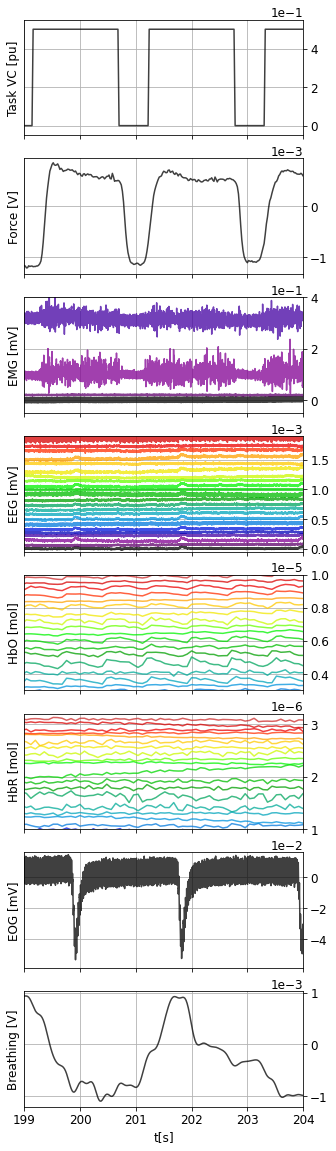

In [19]:
fig, ax = plot_raw(ds, "N", xlim=(199,204), figsize=(5,20))
ax[0].set_ylim([-0.05, 0.55])
ax[2].set_ylim([-.5e-1, 4e-1])
ax[3].set_ylim([-0.5e-4, 1.9e-3])
ax[4].set_ylim([0.3e-5, 1e-5])
ax[5].set_ylim([1e-6, 3.2e-6])

## Understanding `pipelines.py` 
The brief analysis  above is only dependent on the tools found in `utils/pipelines.py`.

The class `Pipeline` is a callable object that is instantiated with a list of callable objects or _"pipeline steps"_.
```
step0 = APipelineStep(args, kwargs)
step1 = AnotherPipelineStep(args, kwargs)
my_pipe = Pipeline([step0, step1], name="FOO")
```
When it is called it just iteratively apply to processes contained in its list and returns the result.

`Pipeline` classes can be named and printed directly to easily trace back any preprocessing applied to any data
```
[In]: print(my_pipe)
[Out]: Pipeline(FOO)
            APipelineStep(args, kwargs)
            AnotherPipelineStep(args, kwargs)
```

_"Pipeline steps"_ need to strictly follow the following convention:
```
class APipelineStep(object):
    """ Pipeline process
    Does something
    """
    def __init__(self, param1, param2):
        """ Parameters that will be needed during the call and define the processing step.
        """
        self._param1 = param1
        self._param2 = param2

    def __repr__(self):
        """ Representation of the processing step that will be used to print
        """
        return f"APipelineStep(param1={self._param1}, param2={self._param[2]})\n"

    def __call__(self, data, events, sfreq, **kwargs):
        """ Executed when instance of object is called
        """
        # Do something using self._param1, and self._param2
        data = foo(data, sfreq, self._param1)
        events = foo1(events, sfreq, self._param2)
        return data, events, sfreq
```

The fundamental _"Pipeline steps"_ are provided in `utils/pipelines.py` and `utils/ica.py`.
In `utils/plots.py` the functions to produce the following plots are provided and are more specific of the data to plot.
Of special interest are the 2D grid plots for EEG and NIRS (`plot_eeg` and `plot_hb`) where it can be seen how to use "scalp_chan_grid".
With the provided structure it should be easy to implement ones own _"Pipeline steps"_ and expand the analysis.

The next cell showcases the previous explanations. 
The rest of the notebook exemplifies the flexibility of the design in terms of the application of pipelines in different streams that can be combined.

Pipeline(FOO)
	EpochExtractor(t_0[s]=-5, t_end[s]=25)
	LabelGatherer()

shape before processing (channels, time_samps): (1, 60548)
shape after processing (labels, trials, channels, time_samps): (2, 10, 1, 1500)


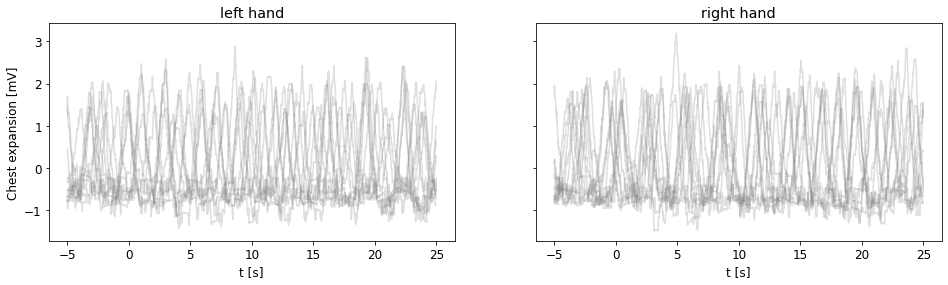

In [20]:
# Declare a pipeline using two steps. 
# The first step extracts epoch from raw data between -5 to 25 s referred to the `Go`. 
# The second steps gather the examples per label so the first axis indexes the 'left' or 'right' hand condition.
foo_pipe = Pipeline(
    [
        EpochExtractor([-5, 25]),
        LabelGatherer()
    ],
    name="FOO"
)

# Print the pipe to easily recall and represent the applied steps
print(foo_pipe)

# Data shape before pipeline
print("shape before processing (channels, time_samps):", ds["B/brt"].shape)

# Apply the pipe to the breathing data of subject B.
# Note how the call to the pipe conforms to convention __call__(data, events, sfreq)
data, events, sfreq = foo_pipe(ds["B/brt"], ds["B/brt"].attrs["events"], ds.attrs["brt_sfreq"])

# Data shape after pipeline 
print("shape after processing (labels, trials, channels, time_samps):", data.shape)

# Plot processed data
fig, ax = plot_brt(data, events, sfreq)

In [6]:
total_time = 0
total_subjects = 0
total_trials_per_hand = 0
for sbj in ds.keys():
    data, events, sfreq = foo_pipe(ds[sbj+"/brt"], ds[sbj+"/brt"].attrs["events"], ds.attrs["brt_sfreq"])
    total_trials_per_hand += data.shape[1]
    total_time += data.shape[-1] / sfreq * data.shape[1]
    total_subjects += 1
    print(sbj, data.shape[1], data.shape[-1]/ds.attrs["brt_sfreq"])
print("time[h] = ", total_time/3600, "subjects = ", total_subjects, "trials =", total_trials_per_hand)

A 10 30.0
B 10 30.0
C 10 30.0
D 10 30.0
E 10 30.0
F 10 30.0
G 13 30.0
H 13 30.0
I 13 30.0
J 13 30.0
K 13 30.0
L 13 30.0
M 13 30.0
N 13 30.0
time[h] =  1.3666666666666667 subjects =  14 trials = 164


# Brief analysis

In [21]:
# Shared parameters
eeg_fs = 250                       # desired eeg sfreq [Hz]
main_f = 50                        # mains frequency [Hz]
nirs_f = ds.attrs["oxy_sfreq"]     # nirs sfreq [Hz] for filtering purposes 
epoch_win = [-5,25]                # window [s] to create trials with trial onset at t = 0s (same for all pipelines to compute correlations later)

## NIRS

Pipeline(NIRS)
	Joiner(axis=-2)
	Filter(type=ellip-lowpass, order=7, sfreq[Hz]=12.5, fn[Hz]= 0.25, gpass[dB]=1, gstop[dB]=60)
	EpochExtractor(t_0[s]=-5, t_end[s]=25)
	LabelGatherer()
	HbConverter(tbound[s]=[4, 5], DPF[1]=[5.98 7.54], SD[cm]=3.0, exc[cm^-1 mol^-1]=[1486.5865 3843.707  2526.391  1798.643 ])



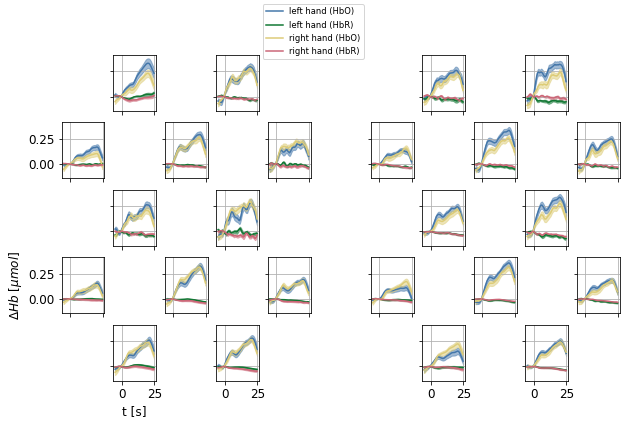

In [14]:
nirs_pipe = Pipeline(
    [
        Joiner(axis=-2),
        Filter([0.25, 0.3], ds.attrs["oi1_sfreq"], gpass=1, gstop=60, filttype="ellip"),
        EpochExtractor(epoch_win),
        LabelGatherer(),                     
        HbConverter(ds.attrs["nirs_DPF"], ds.attrs["nirs_SD"], ds.attrs["nirs_exc"], tbound=[4,5])
    ],
    name="NIRS"
)

print(nirs_pipe)

nirs = []
for sbj in ds.keys():
    x, nirs_evts, nirs_fs = nirs_pipe(ds[sbj+"/oi1"], ds[sbj+"/oi1"].attrs["events"], ds.attrs["oi1_sfreq"], y=ds[sbj+"/oi2"]) 
    nirs.append(x)
nirs = np.concatenate(nirs, axis=1)
fig, ax = plot_hb(nirs, nirs_evts, nirs_fs, ds.attrs["scalp_chan_grid"])
fig.legend(loc="upper center", fontsize="x-small")

## EEG
__NOTES__:<br>
- Some trials in electrical measures have an artefact from -5s to -1s to the start of the trial and from 21 s at the end to 25 s since at this times subjects were allowed to relax.
- The EEG also has electrical noise leaking from the NIRS system LED's sampling at $12.5~$Hz.

### Line noise evaluation

NameError: name 'fr' is not defined

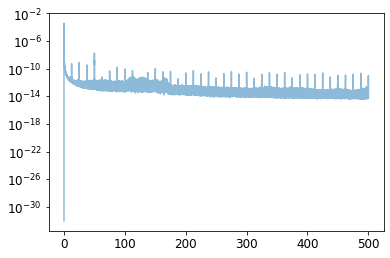

In [22]:
line_n_removal = Pipeline(
      [Filter([main_f*(1+i), Q], ds.attrs["eeg_sfreq"], filttype="notch") for i, Q in enumerate([80]*9)]
    + [Filter([nirs_f*(1+i), Q], ds.attrs["eeg_sfreq"], filttype="notch") for i, Q in enumerate([100]*40)],
    name="line_n_removal"
)

f, Pxx_den = signal.periodogram(ds["A/eeg"], ds.attrs["eeg_sfreq"])
seeg, _, _ = line_n_removal(ds["A/eeg"], ds["A/eeg"].attrs["events"], ds.attrs["eeg_sfreq"])
fs, Pxxs_den = signal.periodogram(seeg, ds.attrs["eeg_sfreq"])
plt.semilogy(f, Pxx_den.mean(axis=0), alpha=0.5)
plt.semilogy(fr, Pxxr_den.mean(axis=0), alpha=0.5)
plt.ylim([1e-18, 1e-3])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
print(ds.attrs["eeg_sfreq"])

In [23]:
# estimated SNR = P_signal / P_noise assuming noise is additive
P_signal = sp.integrate.trapz(Pxxs_den.mean(axis=0), fs)
P_raw = sp.integrate.trapz(Pxx_den.mean(axis=0), f)
P_noise = P_raw - P_signal
SNR = P_signal / P_noise
print(f"SNR = P_signal / P_noise = {P_signal:.2e} V^2 / {P_noise:.2e} V^2 = {SNR:.2f}")

SNR = P_signal / P_noise = 4.58e-07 V^2 / 2.66e-10 V^2 = 1718.48


In [24]:
# Stream A : remove electric noise & removes EOG
ica_fs = 25
ica_mode = "per_condition"
ica_filter = Filter([[1, 3],[0.5, 4]], ica_fs, gpass=3, gstop=30, filttype="butter")
eeg_pipe_a = Pipeline(
    [
        Downsampler(ds.attrs["eeg_sfreq"], eeg_fs)
    ]
    + [Filter([main_f*(1+i), Q], eeg_fs, filttype="notch") for i, Q in enumerate([80,100])]
    + [Filter([nirs_f*(1+i), Q], eeg_fs, filttype="notch") for i, Q in enumerate([100]*9)] 
    + [ 
        Filter([1, 0.5], eeg_fs, gpass=3, gstop=30, filttype="butter"),
        EpochExtractor(epoch_win),
        LabelGatherer(),
        IcaReconstructor(
            ica_fs, max_components=1, threshold=.9, prefilter=ica_filter, max_iter=1000, tolerance=1e-4, 
            tlim=[-1,21], mode=ica_mode, standarize=True
        ),
      ],
    name="EEGa"
)

# Stream B : removes EMG artefacts
ica_fs = 125
ica_filter = Filter([1,0.5], ica_fs, gpass=3, gstop=30, filttype="butter")
eeg_pipe_b = Pipeline(
    [
        IcaReconstructor(
            ica_fs, max_components=1, threshold=1e-3, prefilter=ica_filter, max_iter=1000, tolerance=1e-4, # TODO max_components=2, threshold=1e-4
            tlim=[-5,25], mode=ica_mode, standarize=True
        )
    ],
    name="EEGb"
)

ref_pipe = Pipeline(
    [
        EpochExtractor(epoch_win),
        LabelGatherer() 
    ],
    name="REF"
)

print(eeg_pipe_a)
print(eeg_pipe_b)
print(ref_pipe)

gather_subjects = True
if gather_subjects:
    eeg = []
    for sbj in ds.keys():
        print(f"Processing {sbj}a: ")
        ref, ref_evts, ref_fs = ref_pipe(
            ds[sbj+"/eog"], ds[sbj+"/eog"].attrs["events"], ds.attrs["eog_sfreq"]
        )
        x, eeg_evts, eeg_fs = eeg_pipe_a(
            ds[sbj+"/eeg"], ds[sbj+"/eeg"].attrs["events"], ds.attrs["eeg_sfreq"], 
            ref=ref, ref_evts=ref_evts, ref_fs=ref_fs
        )
        print(f"Processing {sbj}b: ")
        ref, ref_evts, ref_fs = ref_pipe(
            ds[sbj+"/emg"], ds[sbj+"/emg"].attrs["events"], ds.attrs["emg_sfreq"]
        )
        x, eeg_evts, eeg_fs = eeg_pipe_b(
            x, eeg_evts, eeg_fs, 
            ref=ref, ref_evts=ref_evts, ref_fs=ref_fs
        )
        eeg.append(x)
        print()
    eeg = np.concatenate(eeg, axis=1)
print("@done")

Pipeline(EEGa)
	Downsampler(sfreq_in[Hz]=1000.0, sfreq_out[Hz]=250, axis=-1, thres=13)
	Filter(type=notch-bandstop, sfreq[Hz]=250, fn0[Hz]= 50.00, Q[1]=80)
	Filter(type=notch-bandstop, sfreq[Hz]=250, fn0[Hz]= 100.00, Q[1]=100)
	Filter(type=notch-bandstop, sfreq[Hz]=250, fn0[Hz]= 12.50, Q[1]=100)
	Filter(type=notch-bandstop, sfreq[Hz]=250, fn0[Hz]= 25.00, Q[1]=100)
	Filter(type=notch-bandstop, sfreq[Hz]=250, fn0[Hz]= 37.50, Q[1]=100)
	Filter(type=notch-bandstop, sfreq[Hz]=250, fn0[Hz]= 50.00, Q[1]=100)
	Filter(type=notch-bandstop, sfreq[Hz]=250, fn0[Hz]= 62.50, Q[1]=100)
	Filter(type=notch-bandstop, sfreq[Hz]=250, fn0[Hz]= 75.00, Q[1]=100)
	Filter(type=notch-bandstop, sfreq[Hz]=250, fn0[Hz]= 87.50, Q[1]=100)
	Filter(type=notch-bandstop, sfreq[Hz]=250, fn0[Hz]= 100.00, Q[1]=100)
	Filter(type=notch-bandstop, sfreq[Hz]=250, fn0[Hz]= 112.50, Q[1]=100)
	Filter(type=butter-highpass, order=5, sfreq[Hz]=250, fn[Hz]= 1.00, gpass[dB]=3, gstop[dB]=30)
	EpochExtractor(t_0[s]=-5, t_end[s]=25)
	Label

/home/oliver/Data/hygrip/hygrip-master/utils/plots.py:373: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[r, c].pcolormesh(tnew, fnew, Snew, cmap=plt.get_cmap("coolwarm"),vmax=kwargs["scale"][1], vmin=kwargs["scale"][0])


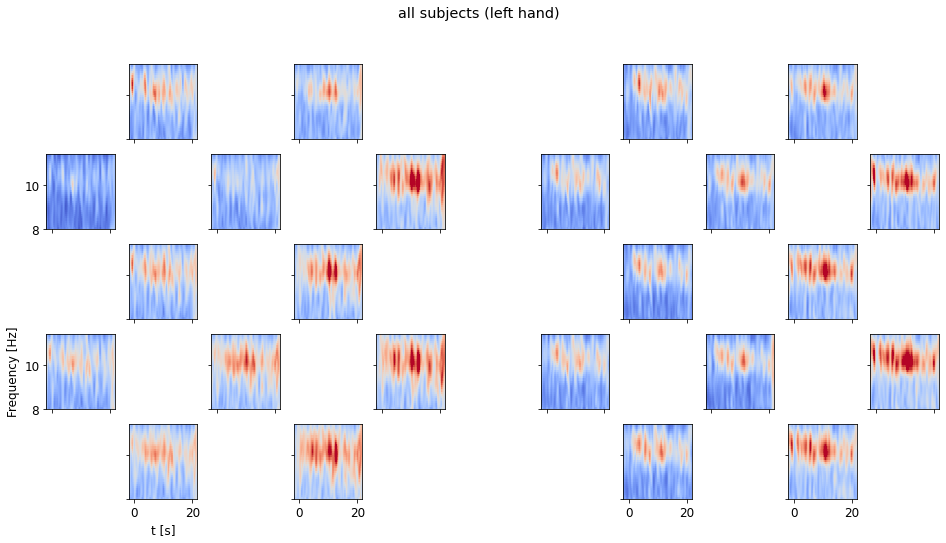

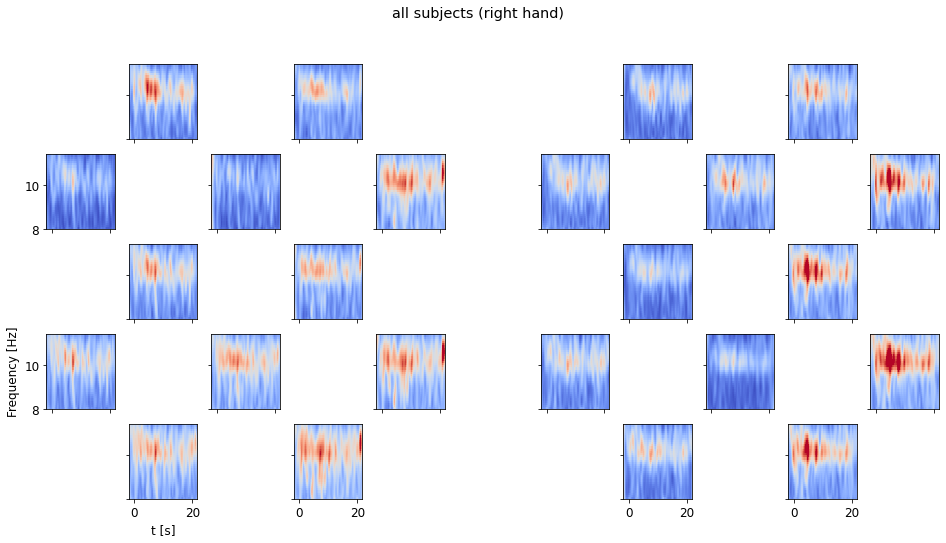

In [25]:
scaling = "density"
kb = "mu"
bands = {"delta":[1,4], "delta+theta":[1,8], "theta":[4,8], "mu":[8,12], "mu+beta": [6,30], "beta":[12,30], "gamma":[30, 60], "high-gamma":[75, 125]}
w = {"delta":3, "mu":2, "beta":2, "gamma":2, "high-gamma":1}
band = bands[kb]
window = signal.windows.hann(int(eeg_fs*w[kb]))
noverlap = window.shape[0] / 1.1

for hand in ["left", "right"]:
    fig, ax = plot_eeg(
        eeg, eeg_evts, eeg_fs, ds.attrs["scalp_chan_grid"], hand, tlim=[-2,22], flim=band, 
        mode="specgram", scaling=scaling, window=window, noverlap=noverlap, scale=[11000,60000]
    )
    fig.suptitle(f"all subjects ({hand} hand)")

## EMG

In [ ]:
emg_fs = eeg_fs
emg_pipe = Pipeline(
    [
        Downsampler(ds.attrs["emg_sfreq"], emg_fs),
        Filter([110, 105], eeg_fs, gpass=2, gstop=40, filttype="butter"),
        EpochExtractor(epoch_win),
        LabelGatherer(),
    ],
    name="EMG"
)

print(emg_pipe)

gather_subjects = True
if gather_subjects:
    emg = []
    for sbj in ds.keys():
        print(f"Processing {sbj}", end="\r")
        x, emg_evts, emg_fs = emg_pipe(
            ds[sbj+"/emg"], ds[sbj+"/emg"].attrs["events"], ds.attrs["emg_sfreq"]
        )
        emg.append(x)
    emg = np.concatenate(emg, axis=1)
    fig, ax = plot_emg_power(emg, emg_evts, emg_fs, face="ant", st_err=False, tbound=[0,0.5])
else:
    for sbj in ds.keys():
        emg, emg_evts, emg_fs = emg_pipe(
            ds[sbj+"/emg"], ds[sbj+"/emg"].attrs["events"], ds.attrs["emg_sfreq"]
        )
        fig, ax = plot_emg_power(emg, emg_evts, emg_fs, face="ant")
        fig.suptitle(sbj)
print("\n@done")

## Force

In [ ]:
frc_pipe = Pipeline(
    [
        Filter([[1e-4, 9], [1e-5, 14]], ds.attrs["frc_sfreq"], gpass=3, gstop=20, filttype="ellip"),
        EpochExtractor(epoch_win),
        Filter([1e-3, 1e-4], ds.attrs["frc_sfreq"], gpass=1, gstop=60, filttype="ellip"),
        LabelGatherer(),                     
        VCconverter(),
    ],
    name="FORCE"
)

print(frc_pipe)

gather_subjects = True
if not gather_subjects:
    for sbj in ds.keys():
        print(f"Processing {sbj}", end="\r")
        force, frc_evts, frc_fs = frc_pipe(ds[sbj+"/frc"], ds[sbj+"/frc"].attrs["events"], ds.attrs["frc_sfreq"], mvc=ds[sbj+"/frc"].attrs["MVC"])
        fig, ax = plot_force(force, frc_evts, frc_fs, plot_task=True)
        fig.suptitle(sbj)
else:
    force = []
    for sbj in ds.keys():
        print(f"Processing {sbj}", end="\r")
        x, frc_evts, frc_fs = frc_pipe(ds[sbj+"/frc"], ds[sbj+"/frc"].attrs["events"], ds.attrs["frc_sfreq"], mvc=ds[sbj+"/frc"].attrs["MVC"])
        force.append(x)
    force = np.concatenate(force, 1)
    fig, ax = plot_force(force, frc_evts, frc_fs, plot_task=True)
    fig.tight_layout()
print("\n@done")

In [ ]:
ds["A/frc"].attrs["events"]

## Confounds

### EOG

In [ ]:
eog_fs = 50
eog_pipe = Pipeline(
    [
        Downsampler(ds.attrs["eog_sfreq"], eog_fs),
        Filter([1, 0.5], eog_fs, gpass=2, gstop=40, filttype="butter"),
        EpochExtractor([-5,25]),
        LabelGatherer()
    ],
    name="EOG"
)
print(eog_pipe)

gather_subjects = True
if gather_subjects:
    eog = []
    for sbj in ds.keys():
        x, eog_evts, eog_fs = eog_pipe(ds[sbj+"/eog"], ds[sbj+"/eog"].attrs["events"], ds.attrs["eog_sfreq"])
        eog.append(x)
    eog = np.concatenate(eog, axis=1)
    fig, ax = plot_eog(eog, eog_evts, eog_fs)
    fig.suptitle("all subjects")
else: 
    for sbj in ds.keys():
        eog, eog_evts, eog_fs = eog_pipe(ds[sbj+"/eog"], ds[sbj+"/eog"].attrs["events"], ds.attrs["eog_sfreq"])
        fig, ax = plot_eog(eog, eog_evts, eog_fs)
        fig.suptitle(sbj)

### Breathing

In [ ]:
brt_pipe = Pipeline(
    [
        Filter([5, 6], ds.attrs["brt_sfreq"], gpass=3, gstop=30, filttype="butter"),
        EpochExtractor(epoch_win),
        LabelGatherer()
    ],
    name="BREATH"
)
print(brt_pipe)

brt = []
for sbj in ds.keys():
    x, brt_evts, brt_fs = brt_pipe(ds[sbj+"/brt"], ds[sbj+"/brt"].attrs["events"], ds.attrs["brt_sfreq"])
    brt.append(x)
brt = np.concatenate(brt, axis=1)
fig, ax = plot_brt(brt, brt_evts, brt_fs)
fig.suptitle("all subjects");

# Correlations

In [ ]:
def compute_regression(x, y):
    """
    x (n_obs, n_vars) endogenous 
    y (n_obs,) exogenous / response
    """
    # Reshape 
    X = x.T
    X = sm.add_constant(X)

    # Compute and fit regression model
    model = sm.OLS(y, X)
    results = model.fit()
    
    return results, x, y

def compute_pcorrelation(x, alpha=None):
    """
    x (n_vars) endogenous 
    """
    # Compute and fit regression model
    r = np.zeros((x.shape[0], x.shape[0]))
    p = np.zeros((x.shape[0], x.shape[0]))
    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            if i <= j:
                r[i,j], p[i,j] = sp.stats.pearsonr(x[i],x[j])
                r[j,i], p[j,i] = r[i,j], p[i,j]
            if alpha is not None and p[i,j] > alpha:
                r[i,j] = 0
                r[j,i] = 0
    return r, p

def eeg_precorr(eeg, eeg_fs, fs_out, band):
    # alpha band filtering
    filt = Filter(band, eeg_fs, gpass=3, gstop=30, filttype="butter")
    eeg, _, _ = filt(eeg, None, eeg_fs)
    # hilbert envelope 
    eeg = signal.hilbert(eeg)
    eeg = np.abs(eeg)
    eeg = np.log(eeg / eeg.mean(-1, keepdims=True))
    # decimate
    eeg = decimate(eeg, eeg_fs, fs_out)
    # standarise
    eeg = (eeg - eeg.mean(-1, keepdims=True)) / eeg.std(-1, keepdims=True)
    return eeg

def emg_precorr(emg, emg_fs, fs_out):
    # band filtering
    filt = Filter([[80,115],[72,120]], emg_fs, gpass=3, gstop=30, filttype="butter")
    emg, _, _ = filt(emg, None, emg_fs)
    # hilbert envelope 
    emg = signal.hilbert(emg)
    emg = np.abs(emg)
    emg = np.log(emg / emg.mean(-1, keepdims=True))
    # decimate
    emg = decimate(emg, emg_fs, fs_out)
    # standarise
    emg = (emg - emg.mean(-1, keepdims=True)) / emg.std(-1, keepdims=True)
    return emg

def force_precorr(force, force_fs, fs_out):
    force = decimate(force, force_fs, fs_out)
    force = (force - force.mean(-1, keepdims=True)) / force.std(-1, keepdims=True)
    return force

def nirs_precorr(nirs, nirs_fs, fs_out):
    if nirs_fs != fs_out:
        nirs = decimate(nirs, nirs_fs, fs_out)
    nirs = (nirs - nirs.mean(-1, keepdims=True)) / nirs.std(-1, keepdims=True)
    return nirs

def compute_corr(eeg, eeg_fs, emg, emg_fs, force, frc_fs, nirs, nirs_fs, condition, fs_out=12.5, tlim=None, t_on=None, alpha=None):
    
    signals, labels = [], []
    
    labels += [r"EEG:$\mu$ L", r"EEG:$\mu$ R"]
    if tlim is None:
        inds = [0,-1]
    else:  
        times = np.arange(eeg.shape[-1]) / eeg_fs - t_on
        inds = [np.argmin(np.abs(t-times)) for t in tlim]
    signals.append(eeg_precorr(eeg[condition,:,[3,15],inds[0]:inds[1]], eeg_fs, fs_out, [[8,12],[6,14]]))
    
    labels += [r"EEG:$\beta$ L", r"EEG:$\beta$ R"]
    if tlim is None:
        inds = [0,-1]
    else:  
        times = np.arange(eeg.shape[-1]) / eeg_fs - t_on
        inds = [np.argmin(np.abs(t-times)) for t in tlim]
    signals.append(eeg_precorr(eeg[condition,:,[3,15],inds[0]:inds[1]], eeg_fs, fs_out, [[12,30],[10,35]]))
    
    labels += [r"EEG$\gamma$ L", r"EEG$\gamma$ R"]
    if tlim is None:
        inds = [0,-1]
    else:  
        times = np.arange(eeg.shape[-1]) / eeg_fs - t_on
        inds = [np.argmin(np.abs(t-times)) for t in tlim]
    signals.append(eeg_precorr(eeg[condition,:,[3,15],inds[0]:inds[1]], eeg_fs, fs_out, [60,55]))
    
    labels += ["HbO L", "HbR L", "HbO R", "HbR R"]
    if tlim is None:
        inds = [0,-1]
    else:  
        times = np.arange(nirs.shape[-1]) / nirs_fs - t_on
        inds = [np.argmin(np.abs(t-times)) for t in tlim]
    signals.append(nirs_precorr(nirs[condition,:,[6,7,30,31],inds[0]:inds[1]], nirs_fs, fs_out))
    
    labels += ["EMG L", "EMG R"]
    if tlim is None:
        inds = [0,-1]
    else:  
        times = np.arange(emg.shape[-1]) / emg_fs - t_on
        inds = [np.argmin(np.abs(t-times)) for t in tlim]
    signals.append(emg_precorr(emg[condition,:,[0,2],inds[0]:inds[1]], emg_fs, fs_out))  # take only anterior channel
    
    labels += ["FORCE"]
    if tlim is None:
        inds = [0,-1]
    else:  
        times = np.arange(force.shape[-1]) / frc_fs - t_on
        inds = [np.argmin(np.abs(t-times)) for t in tlim]
    z = force_precorr(force[condition,...,inds[0]:inds[1]], frc_fs, fs_out)
    signals.append(np.moveaxis(z, 0, 1))

    min_len = min([l.shape[-1] for l in signals])
    X = np.concatenate([s[...,:min_len] for s in signals])
    
    # Make last axis all observations
    X = X.reshape((X.shape[0],-1), order='F')
    
    # X (vars, obs)
    R, p = compute_pcorrelation(X, alpha=alpha)
    
    # Compute regression with force
    res, _, _ = compute_regression(X[:-1], X[-1])
    print(res.summary(xname=["bias"]+labels[:-1]))

    return R, p, labels


## Brain & behaviour

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     498.4
Date:                Wed, 22 Jul 2020   Prob (F-statistic):               0.00
Time:                        10:37:08   Log-Likelihood:                -3969.5
No. Observations:                4100   AIC:                             7965.
Df Residuals:                    4087   BIC:                             8047.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bias           6.072e-17      0.010   6.09e-15

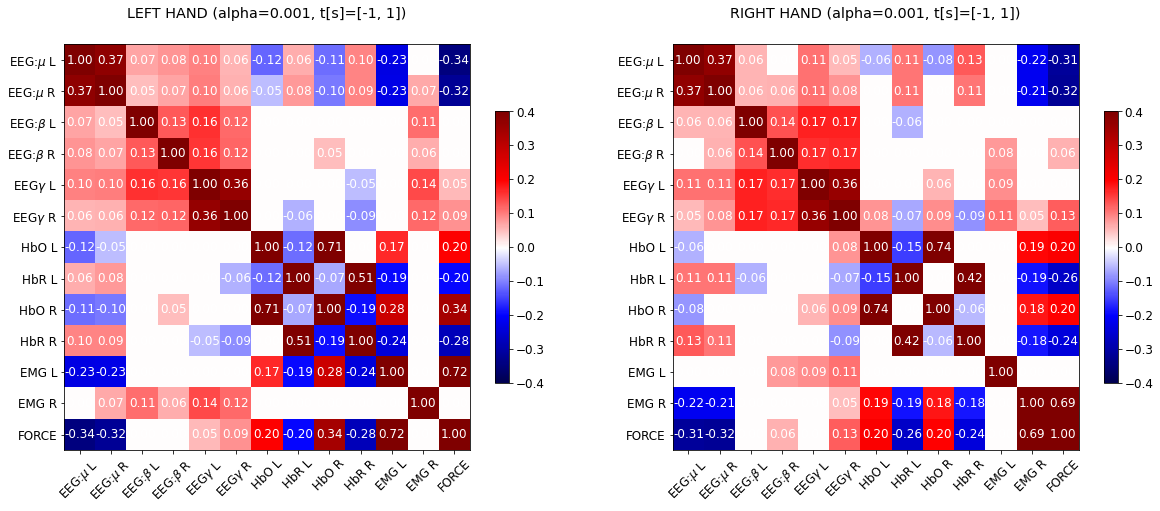

In [16]:
tlim = [-1,1]
alpha = 0.001
R_left, p, _ = compute_corr(eeg, eeg_fs, emg, emg_fs, force, frc_fs, nirs, nirs_fs, 0, tlim=tlim, t_on=eeg_evts[0,0,0], alpha=alpha)
R_right, p, labels = compute_corr(eeg, eeg_fs, emg, emg_fs, force, frc_fs, nirs, nirs_fs, 1, tlim=tlim, t_on=eeg_evts[0,0,0], alpha=alpha)

clamp = 1e-3
plot_triang = False
norm = matplotlib.colors.Normalize(vmin=-.4, vmax=+.4, clip=False)
fig, ax = plt.subplots(1,2,figsize=(20,10))
for i, R in enumerate([R_left, R_right]):
    im = ax[i].matshow(R, cmap="seismic", norm=norm)
    for j in range(R.shape[0]):
        for k in range(R.shape[1]):
            text = ax[i].text(k, j, f"{R[j, k]:2.2f}", ha="center", va="center", color="w")
    plt.colorbar(im, ax=ax[i], shrink=0.5)
    ax[i].tick_params(axis='x', bottom=True, labelbottom=True, top=False, labeltop=False) 
    ax[i].set_xticks(np.arange(len(labels)))
    ax[i].set_xticklabels(labels=labels, rotation="45", ha="center") 
    ax[i].set_yticks(np.arange(len(labels)))
    ax[i].set_yticklabels(labels)
    ax[i].set_title(["LEFT","RIGHT"][i]+f" HAND (alpha={alpha}, t[s]={tlim})")

## Brain & confounds

In [17]:
def breath_precorr(breath, num_samps):
    breath = signal.resample(breath.T, num_samps).T
    breath = (breath - breath.mean(-1, keepdims=True)) / breath.std(-1, keepdims=True)
    return breath

def eog_precorr(eog, eog_fs, fs_out):
    eog = decimate(eog, eog_fs, fs_out)
    eog = (eog - eog.mean(-1, keepdims=True)) / eog.std(-1, keepdims=True)
    return eog

def compute_corr_2(eeg, eeg_fs, eog, eog_fs, nirs, nirs_fs, breath, breath_fs, condition, tlim=None, t_on=0, fs_out=12.5, alpha=None):
    
    signals, labels = [], []
    
    labels += [r"EEG$\mu$"]
    if tlim is None:
        inds = [0,-1]
    else:  
        times = np.arange(eeg.shape[-1]) / eeg_fs - t_on
        inds = [np.argmin(np.abs(t-times)) for t in tlim]
    z = eeg_precorr(eeg[condition,:,3:4,inds[0]:inds[1]], eeg_fs, fs_out, [[8,12],[6,14]])
    signals.append(np.moveaxis(z, 0, 1)) 
    
    labels += ["HbO","HbR"]
    if tlim is None:
        inds = [0,-1]
    else:  
        times = np.arange(nirs.shape[-1]) / nirs_fs - t_on
        inds = [np.argmin(np.abs(t-times)) for t in tlim]
    signals.append(nirs_precorr(nirs[condition,:,[6,7],inds[0]:inds[1]], nirs_fs, fs_out))
    
    labels += ["EOG"]
    if tlim is None:
        inds = [0,-1]
    else:  
        times = np.arange(eog.shape[-1]) / eog_fs - t_on
        inds = [np.argmin(np.abs(t-times)) for t in tlim]
    z = eog_precorr(eog[condition,...,inds[0]:inds[1]], eog_fs, fs_out)
    signals.append(np.moveaxis(z, 0, 1))  
    
    labels += ["BREATH."]
    if tlim is None:
        inds = [0,-1]
    else:  
        times = np.arange(breath.shape[-1]) / breath_fs - t_on
        inds = [np.argmin(np.abs(t-times)) for t in tlim]
    z = breath_precorr(breath[condition,...,inds[0]:inds[1]], z.shape[-1]) # introduces num_samples to upsample
    signals.append(np.moveaxis(z, 0, 1))
    
    min_len = min([l.shape[-1] for l in signals])
    X = np.concatenate([s[...,:min_len] for s in signals])
    
    # Make last axis all observations
    X = X.reshape((X.shape[0],-1), order='F')
    
    # X (vars, obs)
    R, p = compute_pcorrelation(X, alpha=alpha)
    
    # Compute regression with force
    res, _, _ = compute_regression(X[:-1], X[-1])
    print(res.summary(xname=["bias"]+labels[:-1]))
    
    return R, p, labels

In [18]:
tlim = [-1,1]
R_left, p, _ = compute_corr_2(eeg, eeg_fs, eog, eog_fs, nirs, nirs_fs, brt, brt_fs, 0, tlim=tlim, t_on=eeg_evts[0,0,0], fs_out=2.5, alpha=alpha)
R_right, p, labels = compute_corr_2(eeg, eeg_fs, eog, eog_fs, nirs, nirs_fs, brt, brt_fs, 1, tlim=tlim, t_on=eeg_evts[0,0,0], fs_out=2.5, alpha=alpha)

plt_triang = False
norm = matplotlib.colors.Normalize(vmin=-.4, vmax=+.4, clip=False)
fig, ax = plt.subplots(1,2,figsize=(16,8))
for i, R in enumerate([R_left, R_right]):
    for l in range(R.shape[0]):
        for m in range(R.shape[1]):
            if np.abs(R[l,m]) < clamp:
                R[l,m] = 0
            if plot_triang and l <= m:
                R[l,m] = 0
    im = ax[i].matshow(R, cmap="seismic", norm=norm)
    for j in range(R.shape[0]):
        for k in range(R.shape[1]):
            text = ax[i].text(k, j, f"{R[j, k]:2.2f}", ha="center", va="center", color="w")
    plt.colorbar(im, ax=ax[i], shrink=0.5)
    ax[i].tick_params(axis='x', bottom=True, labelbottom=True, top=False, labeltop=False) 
    ax[i].set_xticks(np.arange(len(labels))) 
    ax[i].set_xticklabels(labels, rotation="45", ha="center") 
    ax[i].set_yticks(np.arange(len(labels))) 
    ax[i].set_yticklabels(labels)
    ax[i].set_title(["LEFT","RIGHT"][i]+f" HAND (alpha = {alpha}, t[s]={tlim})")

ValueError: The length of the input vector x must be greater than padlen, which is 27.